In [4]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import BRICS
import rdkit
rdkit.__version__
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
ms = [x for x in Chem.SmilesMolSupplier('../data/BLSets_selected_actives.txt')]
len(ms)

6359

In [6]:
list(BRICS.FindBRICSBonds(ms[0]))

[((2, 1), ('1', '5')),
 ((8, 7), ('1', '5')),
 ((6, 7), ('4', '5')),
 ((15, 20), ('5', '12')),
 ((8, 10), ('6', '13')),
 ((6, 30), ('8', '15')),
 ((23, 24), ('8', '16'))]

In [7]:
from collections import defaultdict, Counter
cntr = Counter()
for m in ms:
    bbnds = BRICS.FindBRICSBonds(m)
    for aids,lbls in bbnds:
        cntr[lbls] += 1
freqs = sorted([(y,x) for x,y in cntr.items()],reverse=True)
freqs[:10]

[(7337, ('4', '5')),
 (4619, ('1', '5')),
 (3488, ('8', '16')),
 (2599, ('3', '16')),
 (1817, ('5', '16')),
 (1507, ('3', '4')),
 (997, ('6', '16')),
 (853, ('5', '15')),
 (790, ('8', '14')),
 (714, ('8', '15'))]

In [8]:
bondsToKeep = [y for x,y in freqs[:10]]


In [28]:
tm=Chem.FragmentOnSomeBonds(ms[0],[ms[0].GetBondBetweenAtoms(2,1).GetIdx(),ms[0].GetBondBetweenAtoms(8,7).GetIdx()],
                         dummyLabels=[[1,5],[1,5]])
[Chem.MolToSmiles(x) for x in tm]

['[1*]C(=O)C(=O)C(NC(=O)[C@@H]1CC[C@H]2CN(S(=O)(=O)Cc3ccccc3)CC(=O)N21)[C@H]1CC[C@H](N)CC1.[5*]NC',
 '[1*]C(=O)[C@@H]1CC[C@H]2CN(S(=O)(=O)Cc3ccccc3)CC(=O)N21.[5*]NC(C(=O)C(=O)NC)[C@H]1CC[C@H](N)CC1']

[1*]C(=O)C(=O)C(NC(=O)[C@@H]1CC[C@H]2CN(S(=O)(=O)Cc3ccccc3)CC(=O)N21)[C@H]1CC[C@H](N)CC1.[5*]NC


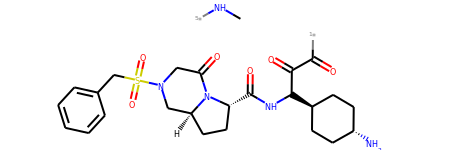

In [25]:
tm=Chem.FragmentOnSomeBonds(ms[0],[ms[0].GetBondBetweenAtoms(2,1).GetIdx()],
                         dummyLabels=[[1,5]])[0]
print(Chem.MolToSmiles(tm))
tm

In [9]:
def splitMol(mol,bondsToKeep):
    bbnds = BRICS.FindBRICSBonds(mol)
    bndsToTry = []
    lbls = []
    for aids,lbl in bbnds:
        if lbl in bondsToKeep:
            bndsToTry.append(mol.GetBondBetweenAtoms(aids[0],aids[1]).GetIdx())
            lbls.append([int(x) for x in lbl])
    if not bndsToTry:
        return []
    res = Chem.FragmentOnSomeBonds(mol,bndsToTry,dummyLabels=lbls)
    for entry in res:
        entry.UpdatePropertyCache(False)
        Chem.FastFindRings(entry)
    return res

def getDifferenceFPs(mol,bondsToKeep,fpgen):
    frags = splitMol(mol,bondsToKeep)
    if not frags:
        return []
    res = []
    molfp = fpgen.GetCountFingerprint(mol)
    for frag in frags:
        ffp = fpgen.GetCountFingerprint(frag)
        res.append(molfp-ffp)
    return res

def getSumFP(fragMol,fpgen,delta):
    ffp = fpgen.GetCountFingerprint(fragMol)
    for idx,v in delta.GetNonzeroElements().items():
        tv = ffp[idx] + v
        if tv<0:
            tv = 0;
        ffp[idx] = tv
    return ffp
        

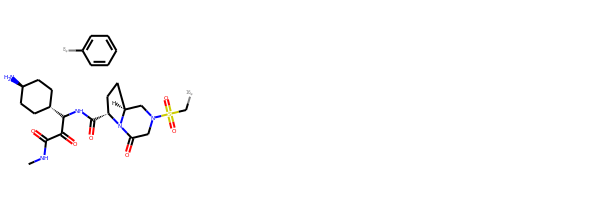

In [59]:
frags = splitMol(ms[0],bondsToKeep[2:3])
Draw.MolsToGridImage(frags)

In [84]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
dfps= []
for m in ms:
    dfps.extend(getDifferenceFPs(m,bondsToKeep[1:2],fpgen))

In [85]:
delta1 = dfps[0]
for dfp in dfps[1:]:
    delta1 += dfp
nfps = len(dfps)
for k,v in delta1.GetNonzeroElements().items():
    delta1[k] = round(v/nfps)
delta1.GetNonzeroElements()

{226: -2, 264: -1, 1831: -1}

In [95]:
allfps = []
for m in ms:
    frags = splitMol(m,bondsToKeep[1:2])
    if not frags:
        continue
    fp1 = fpgen.GetCountFingerprint(m)
    ffps = [getSumFP(x,fpgen,delta1) for x in frags]
    allfps.append((fp1,ffps))

In [96]:
len(allfps)

2801

In [106]:
self_tanis = []
for fp1,ffps in allfps:
    self_tanis.extend([DataStructs.TanimotoSimilarity(fp1,x) for x in ffps])

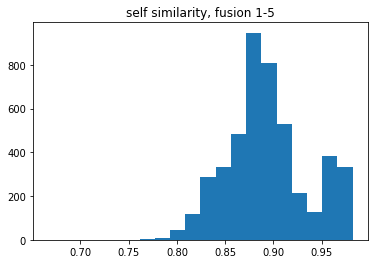

In [107]:
hist(self_tanis,bins=20);
title("self similarity, fusion 1-5");

In [116]:
import random
random.seed(0xf00d)
ps1 = list(range(len(allfps)))
random.shuffle(ps1)
ps1 = ps1[:500]
ps2 = list(range(len(allfps)))
random.shuffle(ps2)
ps2 = ps2[:500]

nCompared = 0
other_tanidiff = []
for i in ps1:
    fp1,frags1 = allfps[i]
    for j in ps2:
        fp2,frags2 = allfps[j]
        refTani = DataStructs.TanimotoSimilarity(fp1,fp2)
        if refTani < 0.3:
            continue
        nCompared += 1
        ltanis = []
        for f1 in frags1:
            ltanis.extend(DataStructs.BulkTanimotoSimilarity(f1,frags2))
        other_tanidiff.extend([refTani-x for x in ltanis])
print(f"considered {nCompared} fingerprint pairs from {len(allfps)**2}")

considered 15242 fingerprint pairs from 7845601


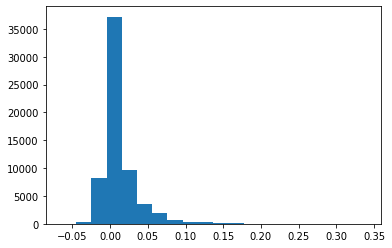

In [113]:
hist(other_tanidiff,bins=20);

In [114]:
len(other_tanidiff)

62521

In [13]:
import random
random.seed(0xf00d)
results = {}
for btk in bondsToKeep:
    print(f"Doing {btk}")
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)
    dfps= []
    for m in ms:
        dfps.extend(getDifferenceFPs(m,[btk],fpgen))

    delta1 = dfps[0]
    for dfp in dfps[1:]:
        delta1 += dfp
    nfps = len(dfps)
    for k,v in delta1.GetNonzeroElements().items():
        delta1[k] = round(v/nfps)
    delta1.GetNonzeroElements()

    allfps = []
    for m in ms:
        frags = splitMol(m,[btk])
        if not frags:
            continue
        fp1 = fpgen.GetCountFingerprint(m)
        ffps = [getSumFP(x,fpgen,delta1) for x in frags]
        allfps.append((fp1,ffps))

    self_tanis = []
    for fp1,ffps in allfps:
        self_tanis.extend([DataStructs.TanimotoSimilarity(fp1,x) for x in ffps])
        
    ps1 = list(range(len(allfps)))
    random.shuffle(ps1)
    ps1 = ps1[:1000]
    ps2 = list(range(len(allfps)))
    random.shuffle(ps2)
    ps2 = ps2[:1000]

    nCompared = 0
    other_tanidiff1 = []
    other_tanidiff2 = []
    for i in ps1:
        fp1,frags1 = allfps[i]
        for j in ps2:
            fp2,frags2 = allfps[j]
            refTani = DataStructs.TanimotoSimilarity(fp1,fp2)
            if refTani < 0.3:
                continue
            nCompared += 1
            ltanis = []
            for f1 in frags1:
                ltanis.extend(DataStructs.BulkTanimotoSimilarity(f1,frags2))
            other_tanidiff1.extend([refTani-x for x in ltanis])
            other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp1,frags2)])
            other_tanidiff2.extend([refTani-x for x in DataStructs.BulkTanimotoSimilarity(fp2,frags1)])

    print(f"considered {nCompared} fingerprint pairs from {len(allfps)**2}")
    results[btk] = (self_tanis,other_tanidiff1,other_tanidiff2)


Doing ('4', '5')
considered 66349 fingerprint pairs from 18326961
Doing ('1', '5')
considered 62647 fingerprint pairs from 7845601
Doing ('8', '16')
considered 53842 fingerprint pairs from 6095961
Doing ('3', '16')
considered 94010 fingerprint pairs from 4260096
Doing ('5', '16')
considered 214678 fingerprint pairs from 2725801
Doing ('3', '4')
considered 110353 fingerprint pairs from 1537600
Doing ('6', '16')
considered 97315 fingerprint pairs from 790321
Doing ('5', '15')
considered 53424 fingerprint pairs from 640000
Doing ('8', '14')
considered 43312 fingerprint pairs from 504100
Doing ('8', '15')
considered 35070 fingerprint pairs from 352836


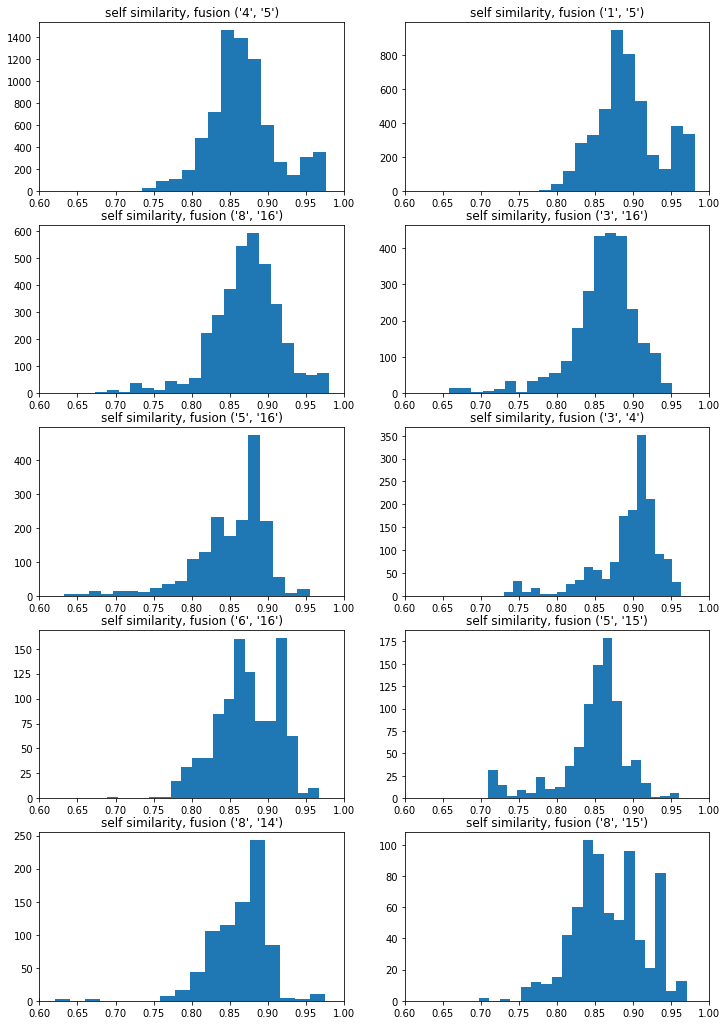

In [14]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(self_tanis,bins=20);
    title(f"self similarity, fusion {btk}");    
    xlim((0.6,1.0))

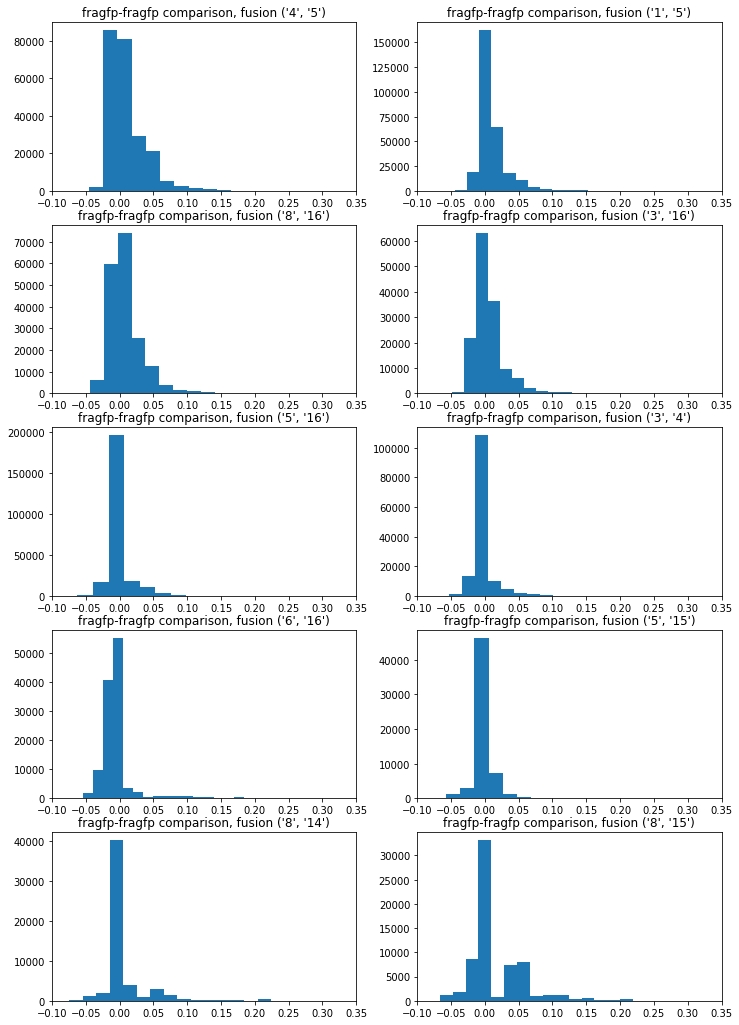

In [17]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(other_tanidiff1,bins=20);
    title(f"fragfp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.35));

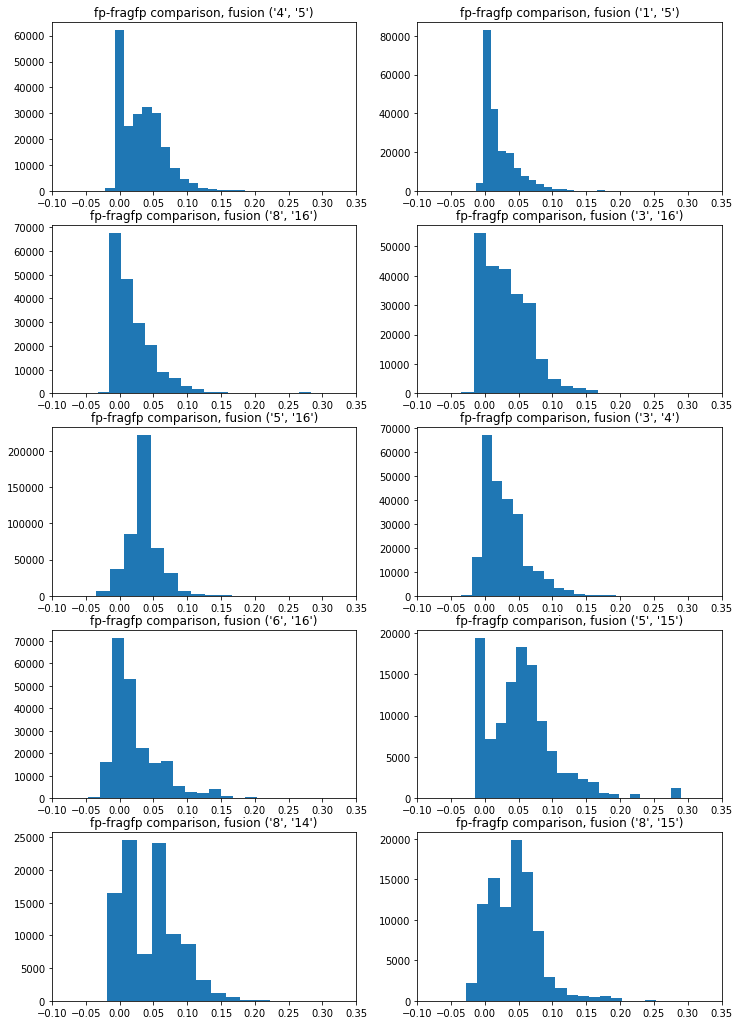

In [18]:
figsize(12,18)
for i,btk in enumerate(results.keys()):
    subplot(5,2,i+1)
    self_tanis,other_tanidiff1,other_tanidiff2 = results[btk]
    hist(other_tanidiff2,bins=20);
    title(f"fp-fragfp comparison, fusion {btk}");
    #yscale('log')
    xlim((-0.1,0.35));